## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch
import torch.nn as nn
import torch.optim as optim
import random

In [2]:
random.seed(42)
np.random.seed(42)
torch.random.manual_seed(42)

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [3]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

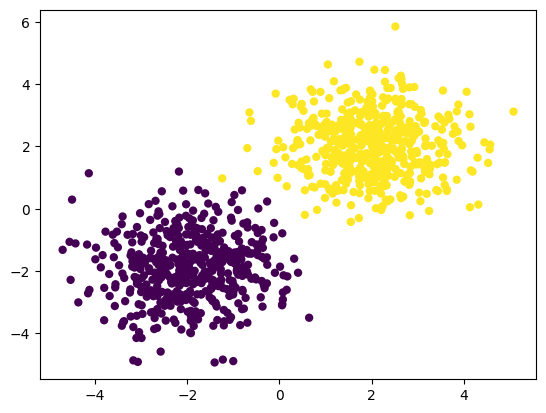

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-3, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

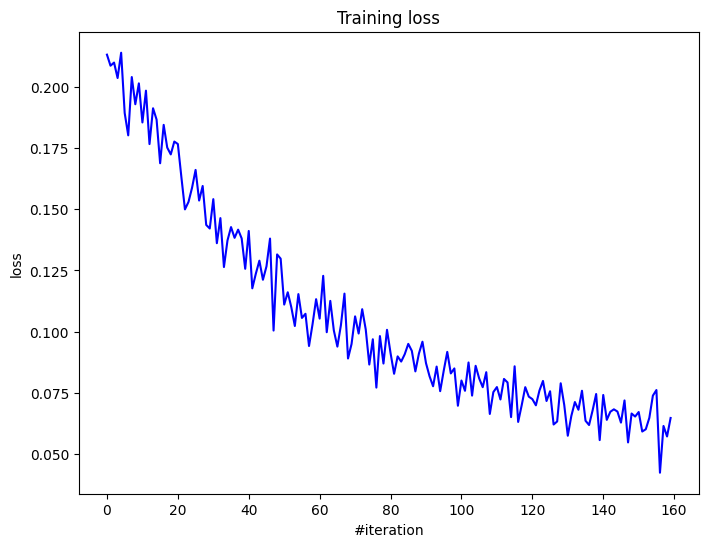

Current loss: 0.064721


In [8]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
    
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [10]:
def one_hot_labels(y):
    res = np.zeros((y.shape[0], 10))
    for i in range(y.shape[0]):
        res[i][y[i]] = 1
    return res
y_train = one_hot_labels(y_train)
y_test = one_hot_labels(y_test)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [11]:
optimizer_config = {'learning_rate' : 5e-3, 'momentum': 0.9}

n_epoch = 20
batch_size = 512
loader={'train':(X_train, y_train),'test':(X_test, y_test)}
criterion = ClassNLLCriterion()

In [13]:
def train_model(model, max_epochs, optimizer, optimizer_config, loader = loader):
    optimizer_state = {}
    loss_history = []
    accuracy = []
    for epoch in range(max_epochs):
        for k, dataloader in loader.items():
            loss_sum = 0
            ch = 0
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in get_batches(dataloader, batch_size):
                ch += 1
                if k == "train":
                    model.train()
                    model.zeroGradParameters()
        
                    
                    predictions = model.forward(x_batch)
                
                    loss = criterion.forward(predictions, y_batch)
                
                    
                    dp = criterion.backward(predictions, y_batch)
                    model.backward(x_batch, dp)
                    
                    
                    optimizer(model.getParameters(), 
                                model.getGradParameters(), 
                                optimizer_config,
                                optimizer_state)      
                else:
                    model.evaluate() 
                    predictions = model.forward(x_batch)
                    loss = criterion.forward(predictions, y_batch)
                    epoch_correct += np.sum(np.argmax(y_batch,axis = 1) == np.argmax(predictions,axis = 1))
                    epoch_all += y_batch.shape[0]
                loss_sum += loss
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Loss: {loss_sum/ch}")
            if k=="test":
                print("\t      Accuracy:", epoch_correct/epoch_all)
                loss_history.append(loss_sum/ch)
                accuracy.append(epoch_correct/epoch_all)
    return loss_history, accuracy

In [14]:
res = []
for i in [ReLU, ELU, LeakyReLU, SoftPlus]:
    print(i)
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(784, 300))
    net.add(i())
    net.add(Linear(300, 200))
    net.add(i())
    net.add(Linear(200, 100))
    net.add(i())
    net.add(Linear(100, 10))
    net.add(LogSoftMax())
    res.append(train_model(net, 8, sgd_momentum, optimizer_config)[0])

<class '__main__.ReLU'>
Epoch: 1
Loader: train. Loss: 2.28808871809648
Loader: test. Loss: 2.264837222805631
	      Accuracy: 0.2846
Epoch: 2
Loader: train. Loss: 2.1858712704350545
Loader: test. Loss: 2.0059589826448434
	      Accuracy: 0.5319
Epoch: 3
Loader: train. Loss: 1.486986016349009
Loader: test. Loss: 0.960890715995283
	      Accuracy: 0.7191
Epoch: 4
Loader: train. Loss: 0.7555208929231033
Loader: test. Loss: 0.5857973841412886
	      Accuracy: 0.8262
Epoch: 5
Loader: train. Loss: 0.5296559484142191
Loader: test. Loss: 0.4510941545856091
	      Accuracy: 0.8685
Epoch: 6
Loader: train. Loss: 0.43536248312569503
Loader: test. Loss: 0.3907477911876828
	      Accuracy: 0.8898
Epoch: 7
Loader: train. Loss: 0.38891150511781875
Loader: test. Loss: 0.35487944199164956
	      Accuracy: 0.898
Epoch: 8
Loader: train. Loss: 0.3609803275991074
Loader: test. Loss: 0.3355345288347652
	      Accuracy: 0.9034
<class '__main__.ELU'>
Epoch: 1
Loader: train. Loss: 2.173678792189926
Loader: test

In [15]:
for i in [ReLU, ELU, LeakyReLU, SoftPlus]:
    print(i)
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(784, 300))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(300))
    net.add(i())
    net.add(Linear(300, 200))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(200))
    net.add(i())
    net.add(Linear(200, 100))
    net.add(BatchNormalization())
    net.add(ChannelwiseScaling(100))
    net.add(i())
    net.add(Linear(100, 10))
    net.add(LogSoftMax())
    res.append(train_model(net, 8, sgd_momentum, optimizer_config)[0])

<class '__main__.ReLU'>
Epoch: 1
Loader: train. Loss: 2.2979485602476837
Loader: test. Loss: 2.2887536934421293
	      Accuracy: 0.2066
Epoch: 2
Loader: train. Loss: 2.2645828682537954
Loader: test. Loss: 2.217597599743061
	      Accuracy: 0.4756
Epoch: 3
Loader: train. Loss: 2.100646775043966
Loader: test. Loss: 1.8929369903433577
	      Accuracy: 0.5916
Epoch: 4
Loader: train. Loss: 1.5704402209399584
Loader: test. Loss: 1.1768182262074778
	      Accuracy: 0.7529
Epoch: 5
Loader: train. Loss: 0.8879971695327814
Loader: test. Loss: 0.5951232508351924
	      Accuracy: 0.9049
Epoch: 6
Loader: train. Loss: 0.46101269010856977
Loader: test. Loss: 0.31879104478207704
	      Accuracy: 0.9389
Epoch: 7
Loader: train. Loss: 0.2762033325960678
Loader: test. Loss: 0.22173305780355893
	      Accuracy: 0.9515
Epoch: 8
Loader: train. Loss: 0.19393268494292107
Loader: test. Loss: 0.17332803284446555
	      Accuracy: 0.9589
<class '__main__.ELU'>
Epoch: 1
Loader: train. Loss: 2.259903669113535
Loader

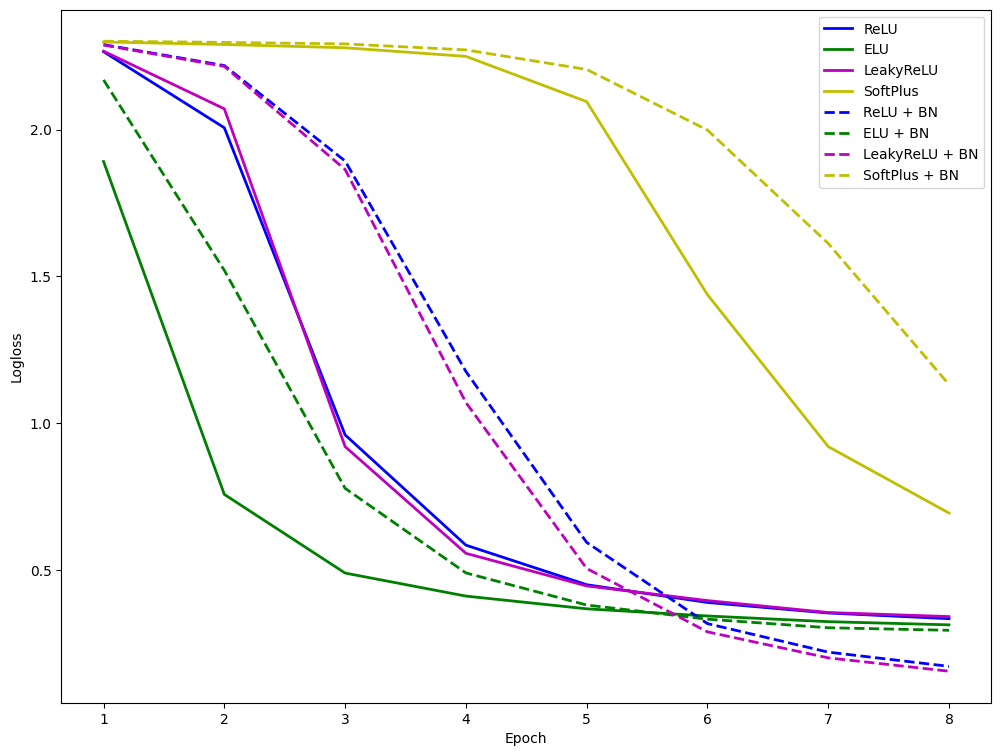

In [17]:
fig, ax = plt.subplots()
ax.plot(range(1, 9), res[0], 'b', label='ReLU', linewidth=2)
ax.plot(range(1, 9), res[1], 'g', label='ELU', linewidth=2)
ax.plot(range(1, 9), res[2], 'm', label='LeakyReLU', linewidth=2)
ax.plot(range(1, 9), res[3], 'y', label='SoftPlus', linewidth=2)

ax.plot(range(1, 9), res[4], '--b', label='ReLU + BN', linewidth=2)
ax.plot(range(1, 9), res[5], '--g', label='ELU + BN', linewidth=2)
ax.plot(range(1, 9), res[6], '--m', label='LeakyReLU + BN', linewidth=2)
ax.plot(range(1, 9), res[7], '--y', label='SoftPlus + BN', linewidth=2)
ax.legend()
fig.set_figheight(9)
fig.set_figwidth(12)
ax.set_ylabel('Logloss')
ax.set_xlabel('Epoch')
plt.show()


Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

* ELU, LeakyReLU, ReLU show the best result. These functions are linear with respect for x > 0, so they are easy to calculate and the gradient does not decay through these functions. But Elu is more expensive to calculate for x<0 due to the exponent. Butchnorm improved the results
* SoftPlus is expensive in terms of computational cost and causes gradient decay, which can be seen in the graph. Batchnorm worsened the rate of convergence due to the fact that the input modulo is less than one and the gradient decays even more. Although if you set more epochs, then it will be better with the batch norm and the result should be no worse than other functions

In [18]:
for i in [(sgd_momentum, {'learning_rate' : 5e-3, 'momentum': 0.9}),
 (adam_optimizer, {'learning_rate': 5e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8})]:
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(784, 300))
    net.add(ReLU())
    net.add(Linear(300, 200))
    net.add(ReLU())
    net.add(Linear(200, 100))
    net.add(ReLU())
    net.add(Linear(100, 10))
    net.add(LogSoftMax())
    res.append(train_model(net, 8, *i)[0])

Epoch: 1
Loader: train. Loss: 2.2938254634507147
Loader: test. Loss: 2.273589369911167
	      Accuracy: 0.3728
Epoch: 2
Loader: train. Loss: 2.2188641105212743
Loader: test. Loss: 2.0995939733250872
	      Accuracy: 0.6205
Epoch: 3
Loader: train. Loss: 1.6309894674980914
Loader: test. Loss: 0.95986769308087
	      Accuracy: 0.743
Epoch: 4
Loader: train. Loss: 0.7351056196274639
Loader: test. Loss: 0.5699321298673796
	      Accuracy: 0.8324
Epoch: 5
Loader: train. Loss: 0.532266188500638
Loader: test. Loss: 0.459563520018046
	      Accuracy: 0.8687
Epoch: 6
Loader: train. Loss: 0.44747257431513454
Loader: test. Loss: 0.3934843069606361
	      Accuracy: 0.8866
Epoch: 7
Loader: train. Loss: 0.3987780941765092
Loader: test. Loss: 0.3641426380081415
	      Accuracy: 0.8922
Epoch: 8
Loader: train. Loss: 0.36799032142407084
Loader: test. Loss: 0.3400480276190841
	      Accuracy: 0.9
Epoch: 1
Loader: train. Loss: 0.4138645153803662
Loader: test. Loss: 0.1526394188719548
	      Accuracy: 0.9513

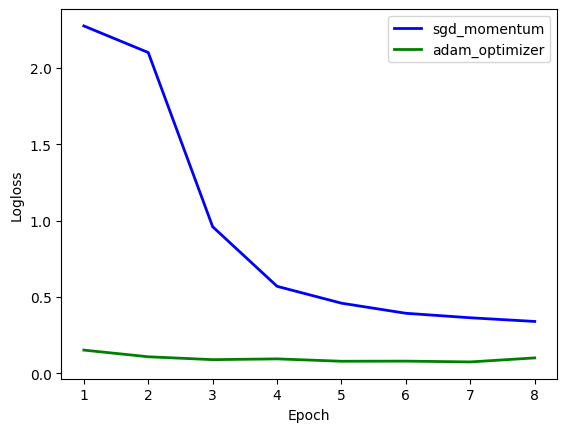

In [19]:
fig, ax = plt.subplots()
ax.plot(range(1, 9), res[-2], 'b', label='sgd_momentum', linewidth=2)
ax.plot(range(1, 9), res[-1], 'g', label='adam_optimizer', linewidth=2)

ax.legend()

ax.set_ylabel('Logloss')
ax.set_xlabel('Epoch')
plt.show()

* Adam converged much faster. But the task is quite simple. Cgd requires less memory, and for large data it is better to use it (since you can take a larger batch size and the estimate will be more stable).

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [20]:
net = Sequential()
net.add(Flatten())
net.add(Linear(784, 300))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(300))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(300, 200))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(200))
net.add(ReLU())
net.add(Dropout())
net.add(Linear(200, 100))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(100))
net.add(ReLU())
net.add(Linear(100, 10))
net.add(LogSoftMax())
res.append(train_model(net, 8, adam_optimizer, {'learning_rate': 5e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8})[1])

Epoch: 1
Loader: train. Loss: 0.7865041763680974
Loader: test. Loss: 0.13525823512660765
	      Accuracy: 0.961
Epoch: 2
Loader: train. Loss: 0.2019812350136175
Loader: test. Loss: 0.10633653262705947
	      Accuracy: 0.9671
Epoch: 3
Loader: train. Loss: 0.16062237634112028
Loader: test. Loss: 0.08648581993188052
	      Accuracy: 0.9744
Epoch: 4
Loader: train. Loss: 0.14554288492469464
Loader: test. Loss: 0.08982307019850119
	      Accuracy: 0.9728
Epoch: 5
Loader: train. Loss: 0.13023786296586365
Loader: test. Loss: 0.08606057387876562
	      Accuracy: 0.9743
Epoch: 6
Loader: train. Loss: 0.11684170417377894
Loader: test. Loss: 0.07573337407214902
	      Accuracy: 0.9765
Epoch: 7
Loader: train. Loss: 0.10703335964875378
Loader: test. Loss: 0.07473378702322223
	      Accuracy: 0.9762
Epoch: 8
Loader: train. Loss: 0.09995187543826643
Loader: test. Loss: 0.07639439267265306
	      Accuracy: 0.978


Print here your accuracy on test set. It should be around 90%.

In [26]:
res[-1][-1]

0.978

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [22]:
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()
loader={'train':(X_train, y_train),'test':(X_test, y_test)}

In [23]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 300),
    nn.BatchNorm1d(300),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(300, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(200, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)
cross = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-3, betas=(0.9, 0.999), eps=1e-08)

In [24]:
accuracy = []
for epoch in range(8):
    for k, dataloader in loader.items():
        loss_sum = 0
        ch = 0
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in get_batches(dataloader, batch_size):
            x_batch = torch.Tensor(x_batch)
            y_batch = torch.LongTensor(y_batch)
            ch += 1
            if k == "train":
                model.train()
                optimizer.zero_grad() 
                outp = model(x_batch)
                loss = cross(outp, y_batch)
                loss.backward() 
                optimizer.step()  
            else:
                model.eval()
                with torch.no_grad():
                    outp = model.forward(x_batch)
                    loss = cross(outp, y_batch) 
                epoch_correct += torch.sum(y_batch == outp.argmax(-1)).item()
                epoch_all += y_batch.shape[0]
            loss_sum += loss.item()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Loss: {loss_sum/ch}")
        if k == "test":
            print("\t      Accuracy:", epoch_correct / epoch_all)
            loss_history.append(loss_sum / ch)
            accuracy.append(epoch_correct / epoch_all)


Epoch: 1
Loader: train. Loss: 0.42826869414777174
Loader: test. Loss: 0.1446365002542734
	      Accuracy: 0.9566
Epoch: 2
Loader: train. Loss: 0.20590072680188684
Loader: test. Loss: 0.10675512962043285
	      Accuracy: 0.9673
Epoch: 3
Loader: train. Loss: 0.16511961863357194
Loader: test. Loss: 0.09271048549562692
	      Accuracy: 0.9713
Epoch: 4
Loader: train. Loss: 0.14144432719568817
Loader: test. Loss: 0.08356232177466154
	      Accuracy: 0.9738
Epoch: 5
Loader: train. Loss: 0.12378862834706598
Loader: test. Loss: 0.07918261270970106
	      Accuracy: 0.9763
Epoch: 6
Loader: train. Loss: 0.11484314056531507
Loader: test. Loss: 0.07617769557982683
	      Accuracy: 0.9772
Epoch: 7
Loader: train. Loss: 0.10744533178453543
Loader: test. Loss: 0.06697174459695816
	      Accuracy: 0.9797
Epoch: 8
Loader: train. Loss: 0.09726517389015275
Loader: test. Loss: 0.06916440762579441
	      Accuracy: 0.9794


In [25]:
accuracy[-1]

0.9794

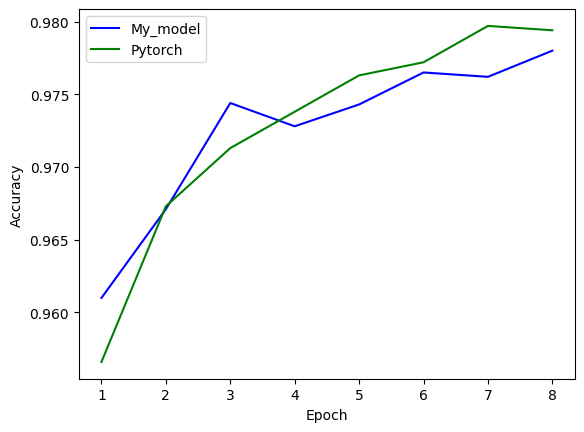

In [29]:
fig, ax = plt.subplots()
ax.plot(range(1, 9), res[-1], 'b', label='My_model')
ax.plot(range(1, 9), accuracy, 'g', label='Pytorch')

ax.legend()

ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
plt.show()